# Deriving Data‑Driven Weights for `complexity_score`


> **Fit a regression on trial duration to let the data pick the weights for each complexity driver**.

Steps covered:

1. **Load** the feature table (`features_v2.parquet`).
2. **Select & scale** candidate variables that plausibly drive operational complexity.
3. **Fit** a regularised linear model (Ridge, with cross‑validated `alpha`) on `log(duration_days)`.
4. **Inspect** the learned coefficients and compare with the current hand‑tuned formula.
5. **Build** a new `complexity_score_reg` and explore its distribution.
6. Optionally **export** the coefficients so you can hard‑code them back into the pipeline.


In [38]:
# Imports & paths
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
import numpy as np, pandas as pd, pickle, json, matplotlib.pyplot as plt
from pathlib import Path

In [39]:
FEATURES_PATH = Path("/Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/"
                     "UCL MSc DSML/MSc Project/data/processed/features_v4.parquet")
ARTIFACT_DIR  = FEATURES_PATH.parent / "complexity_score_artifacts"
ARTIFACT_DIR.mkdir(exist_ok=True)

In [40]:
# Load feature table
df = pd.read_parquet(FEATURES_PATH)
print(f"Loaded {len(df):,} rows")
display(df.head())

Loaded 279,203 rows


,indication/disease area,"rare, non-rare (established disease area and clear diagnosis criteria)","mode of administration (ex. NBE, NCE, iv vs pill)",disease modifying or treating symptoms,population - adults vs peds,phase,# patients,primary_outcomes,secondary_outcomes,other_outcomes,...,age_range,population_class,allocation,randomized_flag,fda_drug_flag,fda_device_flag,patients_per_site,global_trial,complexity_score_100,attractiveness_score_100
0,"""Exposure to Heat""","[{'abbrev': 'BC23', 'name': 'Symptoms and Gene...",OTHER,BASIC_SCIENCE,[ADULT],Unknown,10.0,"[{'description': None, 'measure': 'Investigati...",None,None,...,7.0,Adult,Unknown,0,0,0,10.0,Single,40.239637,28.598280
1,"""Migraine-like"" Headache","[{'abbrev': 'BC10', 'name': 'Nervous System Di...",DRUG,None,[ADULT],Unknown,12.0,[{'description': 'Incidence of headache 0 indi...,[{'description': 'Changes from base line recor...,None,...,37.0,Adult,Randomized,1,0,0,12.0,Single,34.663914,64.399058
2,"""Pulmonary Complications""",None,None,None,"[ADULT, OLDER_ADULT]",Unknown,307.0,"[{'description': None, 'measure': 'Comparison ...",None,None,...,NaN,Adult,Unknown,0,0,0,307.0,Single,57.227230,97.004605
3,(Near) Syncope,"[{'abbrev': 'BC23', 'name': 'Symptoms and Gene...",None,None,"[ADULT, OLDER_ADULT]",Unknown,397.0,"[{'description': None, 'measure': 'adverse eve...","[{'description': None, 'measure': 'prevalence ...",None,...,NaN,Adult,Unknown,0,0,0,397.0,Single,52.245009,80.777221
4,- Egg Hypersensitivity,"[{'abbrev': 'BC20', 'name': 'Immune System Dis...",OTHER,TREATMENT,[CHILD],Phase 1,20.0,[{'description': 'To evaluate the efficacy of ...,"[{'description': 'Before and after SOTI, we ev...",None,...,6.0,Pediatric,Randomized,1,0,0,20.0,Single,30.630451,78.231660


In [41]:
# Column lists (paper spec)
design_cols = [
    "site_n", "country_n", "assessments_n",
    "elig_crit_n", "num_arms", "# patients",
]
target   = np.log(df["duration_days"].values)

In [42]:
# Define inputs (exact paper spec)
design_cols = [
    "site_n",
    "country_n",
    "assessments_n",
    "elig_crit_n",
    "num_arms",
    "# patients",
]

y = np.log(df["duration_days"].values)          # target


In [43]:
# Pre-processing pipeline with imputers
num_pipe = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("pct", QuantileTransformer(output_distribution="uniform",
                                n_quantiles=min(1000, len(df))))
])

pre = ColumnTransformer(
    [("num", num_pipe, design_cols)],
    remainder="drop",
)

In [44]:
# RidgeCV fit
alphas = np.logspace(-3, 3, 31)
ridge  = RidgeCV(alphas=alphas, cv=5, fit_intercept=True)

model = Pipeline([("pre", pre), ("ridge", ridge)])
model.fit(df, target)

print("Best λ:", model.named_steps["ridge"].alpha_)


Best λ: 398.1071705534977


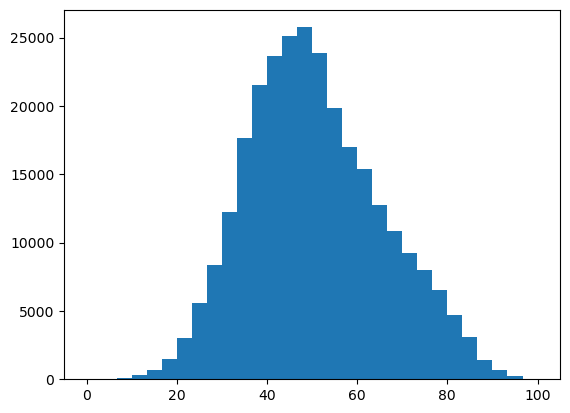

In [45]:
# Extract β and build 0–100 score 
beta = model.named_steps["ridge"].coef_

# raw score
X = model.named_steps["pre"].transform(df)
raw = (X * beta).sum(axis=1)

Smin, Smax = raw.min(), raw.max()
df["complexity_score_100"] = 100 * (raw - Smin) / (Smax - Smin)

plt.hist(df["complexity_score_100"], bins=30); plt.show()


In [46]:
# Save artefacts 
with open(ARTIFACT_DIR / "complexity_score_model.pkl", "wb") as f:
    pickle.dump({
        "pipeline": model,
        "beta": beta,
        "Smin": Smin,
        "Smax": Smax,
        "design_cols": design_cols,
    }, f)

pd.DataFrame({"feature": design_cols,        
              "beta": beta}) \
  .to_json(ARTIFACT_DIR / "complexity_beta.json", orient="records", indent=2)

print("Saved to", ARTIFACT_DIR)


Saved to /Users/jonathanfung/Library/Mobile Documents/com~apple~CloudDocs/UCL MSc DSML/MSc Project/data/processed/complexity_score_artifacts
